In [1]:
import json
import random
import uuid
import numpy as np
import time
import requests
import traceback
import math
import ast
import pandas as pd
import pdb


# Functions

In [2]:
def convert_microtask_dataframe_to_json_set(df):
    microtask_jsons = []
    try:
        for idx, row in df.iterrows():
            print(round((idx+1)/df.shape[0]*100,2),'%',' '*15, end='\r')
            microtask_json = {
                "claim_id": row['claim_id'],
                "verbalised_claim": row['processed_verbalisation'],
                "subject_label": row['entity_label'],
                "subject_description": row['entity_desc'] if row['entity_desc'] != 'no-desc' else "No description available",
                "subject_aliases": ast.literal_eval(row['entity_alias']) if row['entity_alias'] != 'no-alias' else "No aliases available",
                "predicate_label": row['property_label'],
                "predicate_description": row['property_desc'] if row['property_desc'] != 'no-desc' else "No description available",
                "predicate_aliases": ast.literal_eval(row['property_alias']) if row['property_alias'] != 'no-alias' else "No aliases available",
                "object_label": row['object_label'],
                "object_description": row['object_desc'] if row['object_desc'] != 'no-desc' else "No description available",
                "object_aliases": ast.literal_eval(row['object_alias']) if row['object_alias'] != 'no-alias' else "No aliases available",
                "g_id": 0
            }
            microtask_jsons.append(microtask_json)
        return microtask_jsons
    except Exception:
        print(row)
        traceback.print_exc()
        pdb.set_trace()
        raise

In [4]:
#maxSingleInstances = 1 #MAX TIMES ANY REFERENCE APPEARS AMONG THE TASK SETS
#maxSingleInstances_gd = 2

def getRandomTask(counter, n, non_gd_references, maxSingleInstances):
    p = [max(maxSingleInstances-c,0.0001) for c in counter]
    p = [pp/sum(p) for pp in p]
    indexes = np.random.choice(
        a = list(range(len(non_gd_references))),
        size=n,
        replace=False,
        p=p
    )        
    task = []
    for i in indexes:
        reference = non_gd_references[i]
        task.append((reference,i))
    return task

def getRandomGoldenTask(counter, n, gd_references, maxSingleInstances_gd):    
    p = [max(maxSingleInstances_gd-c,0.0001) for c in counter]
    p = [pp/sum(p) for pp in p]
    indexes = np.random.choice(
        a = list(range(len(gd_references))),
        size=n,
        replace=False,
        p=p
    )
    task = []
    for i in indexes:
        reference = gd_references[i]
        task.append((reference,i))
    return task

def generateTaskSet(counter, counter_gd, non_gd_references, gd_references, maxSingleInstances, maxSingleInstances_gd, n=(4,2)):
    '''
    counter = a counter which keeps track of how many times each reference was retrieved
    n = (x,y) where x = number of non_gd references and y = number of gd references
    '''
    taskSet = []
    task = getRandomTask(counter, n[0], non_gd_references, maxSingleInstances)
    taskSet += [r for (r,i) in task] # pairs reference,index are generated here, so that we can update the counter later
    task_gd = getRandomGoldenTask(counter_gd, n[1], gd_references, maxSingleInstances_gd)
    taskSet += [r for (r,i) in task_gd]
    random.shuffle(taskSet)
    return taskSet, [i for (p,i) in task], [i for (p,i) in task_gd] # we return indices here to update counter


def generateIDdTaskSets(non_gd_references, gd_references, maxSingleInstances, maxSingleInstances_gd):
    counter = [0]*len(non_gd_references)
    counter_gd = [0]*len(gd_references)
    taskSets = []
    while (any([c < maxSingleInstances for c in counter])):
        taskSet, indexes, indexes_gd = generateTaskSet(counter, counter_gd, non_gd_references,
                                                       gd_references, maxSingleInstances, maxSingleInstances_gd)
        taskSetIDd = {
            '_id': str(uuid.uuid4()),
            'taskSet' : taskSet
        }
        taskSets.append(taskSetIDd)
        for i in indexes:
            counter[i] = counter[i] + 1
        for i in indexes_gd:
            counter_gd[i] = counter_gd[i] + 1
    return taskSets, counter, counter_gd

# PILOT

In [2]:
data_df = pd.read_csv('./data/pilot/pilot_sampled_df_verbalised.csv')

In [3]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   entity_id                64 non-null     object 
 1   claim_id                 64 non-null     object 
 2   rank                     64 non-null     object 
 3   property_id              64 non-null     object 
 4   datatype                 64 non-null     object 
 5   datavalue                64 non-null     object 
 6   sampling_weight_vb       64 non-null     object 
 7   sampling_weight          64 non-null     float64
 8   entity_label             64 non-null     object 
 9   property_label           64 non-null     object 
 10  object_label             64 non-null     object 
 11  theme_entity_id          64 non-null     object 
 12  theme_entity_label       64 non-null     object 
 13  entity_desc              64 non-null     object 
 14  property_desc            64 

## Remember to
- [ ] CHECK FOR TRIPLES WITH NO LABEL AT ALL!!
- [ ] MAKE BAD GOLDEN CASES EVEN MORE NOTICIABLY BAD

In [4]:
jsonsets = convert_microtask_dataframe_to_json_set(data_df)

## Separate Gold Standard

We now split the json sets into two, one with golden standards and one with references to be judged.

Here is we calculate an appropriate number of gold standards:
- Let X be the maximum expected number of tasks any singular worker can complete;
- Let Y be the number of gold standard references we have annotated;
- Let Z be the number of combinations of 2 gold standard references that we can take from the Y gold standard references in our gold set, regardless of pairing order, without repeating.
- Let P be the probability of a worker doing X tasks and not finding a repeated pair of golden standard references, taken from the set of Z gold standard pairs.

So we calculate:
- Z = Y*(Y-1)/2
- P = Z!/((Z^X)*(Z-X)!)

So, we set X = 15 (The mean number of tasks per worker for previous experiments has been 4, with standard deviation of 10.5, so if it follows a normal distribution, we get 85% of workers here).

According to the calculation below, we see that **Y = 45** gives us near 90% of chances of not having repeated gold standard, so that is how many gold standards we aim at annotating for each language

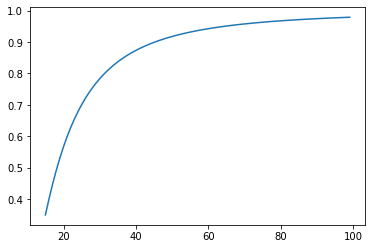

In [5]:
from decimal import Decimal
from decimal import *
import matplotlib.pyplot as plt
def fac(x):
    return Decimal(math.factorial(x))
x = 15
ys = list(range(15,100))
zs = [y*(y-1)/2 for y in ys]
ps = [fac(z)/(Decimal(z**x)*fac(z-x)) for z in zs]
plt.plot(ys,ps)

In [6]:
golden_standard_quota = 6 #should be 45 but we are using 6 for the pilot

random.shuffle(jsonsets)
#with open('data/pilot/verbalisations_gd.json','w+',encoding='utf8') as f:
    #json.dump(jsonsets[:golden_standard_quota], f, indent=2,ensure_ascii=False)
#with open('data/pilot/verbalisations.json','w+',encoding='utf8') as f:
    #json.dump(jsonsets[golden_standard_quota:], f, indent=2,ensure_ascii=False)

IndentationError: expected an indented block (<ipython-input-6-6e66c7b2be24>, line 6)

You must now annotate the golden standard by doing the following:
For each gd reference in the gd json set, go to the "gd" field, which should be like this:
```
{
    "reference_id": [random uuid],
    "url": [an url],
    ...,
    "g_id": 0
}
```

and change it to something of the format:

```
{
    "reference_id": [random uuid],
    "url": [an url],
    ...,
    "g_id": {
        "relevance": {
          "is_present": [0 if it is not present, 1 if it is],
          "difficulty":[a list of numbers from 0 to 4, with 0 to 4 simbolizing possible difficulty answers as seen in the task mockup. Can also be just -1 if it does not matter.],
          "reason":[a list of numbers from 0 to 6, with 0 to 6 simbolizing possible reason answers as seen in the task mockup. Can also be just -1 if it does not matter.]
        },
        "authorit":{
          "author": [a number from 0 to 2 simbolizing the author type as seen in the task mockup],
          "publisher": [a number from 0 to 4 simbolizing the publisher type as seen in the task mockup],
          "sub_publisher": [a number from 0 to the amount of subpublisher types for this publisher type, simbolizing the subpublisher type as seen in the task mockup. It can also be -1 if you don't care for this field.]
        }
    }
}
```

## Generating Task Sets

**Make sure you have annotated the GD before proceeding here**

**Make sure you have also filtered the non-GD for API-verifiable examples**

Now we take 4 non_gd references and 2 gd references and pack them into task sets of 6

In [8]:
print('Generating Task Sets')
with open('data/pilot/verbalisations_gd_2.json','r',encoding='utf8') as f:
    verbalisations_gd = json.load(f)
    print('Gd len:',len(verbalisations_gd))
with open('data/pilot/verbalisations.json','r',encoding='utf8') as f:
    verbalisations = json.load(f)
    print('Non-Gd len:',len(verbalisations))

ds, c, c_gd = generateIDdTaskSets(verbalisations, verbalisations_gd)
print('Generated {} tasks, each verbalisation appearance counter is: {}'.format(len(ds), c))
print('Each golden data appearance counter is: {}'.format(c_gd))

#with open('./data/pilot/TaskSets.json','w+',encoding='utf8') as f:
#    json.dump(ds,f,indent=2)

Generating Task Sets
Gd len: 16
Non-Gd len: 58
Generated 15 tasks, each verbalisation appearance counter is: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1]
Each golden data appearance counter is: [2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1]


# CAMPAIGN

In [5]:
data_df = pd.read_csv('./data/campaign/campaign_sampled_df_verbalised_english.csv')
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6651 entries, 0 to 6650
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   entity_id                6651 non-null   object 
 1   claim_id                 6651 non-null   object 
 2   rank                     6651 non-null   object 
 3   property_id              6651 non-null   object 
 4   datatype                 6651 non-null   object 
 5   datavalue                6651 non-null   object 
 6   sampling_weight_vb       6651 non-null   object 
 7   sampling_weight          6651 non-null   float64
 8   entity_label             6651 non-null   object 
 9   property_label           6651 non-null   object 
 10  object_label             6651 non-null   object 
 11  theme_entity_id          6651 non-null   object 
 12  theme_entity_label       6651 non-null   object 
 13  entity_desc              6651 non-null   object 
 14  property_desc           

In [6]:
data_df.campaign_group.value_counts()

0     159
1     159
4     159
8     159
12    159
13    159
9     159
11    159
7     159
3     159
5     159
2     159
6     159
10    159
14    159
32    158
40    158
36    158
21    158
28    158
24    158
20    158
16    158
17    158
39    158
25    158
34    158
31    158
27    158
23    158
19    158
15    158
38    158
30    158
29    158
26    158
22    158
18    158
41    158
35    158
33    158
37    158
Name: campaign_group, dtype: int64

## Generating Artificial Golden Data

In [72]:
data_df_remaining = data_df[data_df.campaign_group >= 3].reset_index(drop=True) # Taken from not campaigns groups 0,1 and 2

### Generate 45 golden data points with poor fluency

Select these apart and then manually alter them

In [122]:
jsonsets = convert_microtask_dataframe_to_json_set(data_df_remaining.sample(45, random_state=42).reset_index(drop=True))

for jsonset in jsonsets:
    jsonset['g_id'] = {
      "fluency": [0,1,2],
      "adequacy": [0,1,2]
    }  
    jsonset['claim_id'] = jsonset['claim_id'] '_GD_PLUS_FLUENCY'
    jsonset['verbalised_claim'] = jsonset['verbalised_claim'] + ' $ALTER THIS'
    
with open('data/campaign/batch_1/verbalisations_gd_plus_fluency.json','w+',encoding='utf8') as f:
    json.dump(jsonsets[:golden_standard_quota], f, indent=2,ensure_ascii=False)

### Generate 45 golden data points with poor adequacy

Triples are paired with random verbalisations from other triples

In [124]:
jsonsets = convert_microtask_dataframe_to_json_set(data_df_remaining.sample(45, random_state=24783).reset_index(drop=True))
jsonsets_2 = convert_microtask_dataframe_to_json_set(data_df_remaining.sample(45, random_state=1847).reset_index(drop=True))

for i, jsonset in enumerate(jsonsets):
    jsonset['g_id'] = {
      "fluency": [0,1,2,3,4,5],
      "adequacy": [1,2]
    }  
    
    jsonset['claim_id'] = jsonset['claim_id'] '_GD_PLUS_ADEQUACY'    
    jsonset['verbalised_claim'] = jsonsets_2[i]['verbalised_claim']

with open('data/campaign/batch_1/verbalisations_gd_plus_adequacy.json','w+',encoding='utf8') as f:
    json.dump(jsonsets[:golden_standard_quota], f, indent=2,ensure_ascii=False)

## We are first converting campaign batch 1! That is campaign groups 0, 1, and 2

In [45]:
data_df_batch_1 = data_df[data_df.campaign_group < 3].reset_index(drop=True)

In [46]:
jsonsets = convert_microtask_dataframe_to_json_set(data_df_batch_1)

90.78

In [57]:
golden_standard_quota = 45

random.shuffle(jsonsets)
with open('data/campaign/batch_1/verbalisations_gd.json','w+',encoding='utf8') as f:
    json.dump(jsonsets[:golden_standard_quota], f, indent=2,ensure_ascii=False)
with open('data/campaign/batch_1/verbalisations.json','w+',encoding='utf8') as f:
    json.dump(jsonsets[golden_standard_quota:], f, indent=2,ensure_ascii=False)

In [134]:
for task_type in ['fluency','adequacy']:

    print(f'Generating Task Sets for {task_type}')
    with open('data/campaign/batch_1/verbalisations_gd.json','r',encoding='utf8') as f:
        verbalisations_gd = json.load(f)
        print('Gd len:',len(verbalisations_gd))
    with open(f'data/campaign/batch_1/verbalisations_gd_plus_{task_type}.json','r',encoding='utf8') as f:
        verbalisations_gd_plus = json.load(f)
        print('Gd plus len:',len(verbalisations_gd))
    with open('data/campaign/batch_1/verbalisations.json','r',encoding='utf8') as f:
        verbalisations = json.load(f)
        print('Non-Gd len:',len(verbalisations))

    maxSingleInstances = 1 #MAX TIMES ANY REFERENCE APPEARS AMONG THE TASK SETS
    maxSingleInstances_gd = 2

    ds, c, c_gd = generateIDdTaskSets(verbalisations, verbalisations_gd + verbalisations_gd_plus, maxSingleInstances, maxSingleInstances_gd)
    print('Generated {} tasks, each verbalisation appearance counter is: {}'.format(len(ds), c))
    print('Each golden data appearance counter is: {}'.format(c_gd))


    with open(f'./data/campaign/batch_1/TaskSets_{task_type}.json','w+',encoding='utf8') as f:
        json.dump(ds,f,indent=2)

Generating Task Sets
Gd len: 45
Gd plus len: 45
Non-Gd len: 432
Generated 108 tasks, each verbalisation appearance counter is: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

## We are now converting campaign batch 2! That is campaign groups 10,15,20,25,30,35

In [7]:
selected_cgs = [10,15,20,25,30,35]
data_df_batch_2 = data_df[data_df.campaign_group.apply(lambda x : x in selected_cgs)].reset_index(drop=True)

In [10]:
jsonsets = convert_microtask_dataframe_to_json_set(data_df_batch_2)

In [12]:
# WE WILL USE THE SAME GOLD DATA AS FOR BATCH 1, NO NEED TO ANNOTATE MORE IF THOSE WORKED

random.shuffle(jsonsets)
with open('data/campaign/batch_2/verbalisations.json','w+',encoding='utf8') as f:
    json.dump(jsonsets, f, indent=2,ensure_ascii=False)

In [28]:
for task_type in ['fluency','adequacy']:

    print(f'Generating Task Sets for {task_type}')
    with open('data/campaign/batch_1/verbalisations_gd.json','r',encoding='utf8') as f:
        verbalisations_gd = json.load(f)
        print('Gd len:',len(verbalisations_gd))
    with open(f'data/campaign/batch_1/verbalisations_gd_plus_{task_type}.json','r',encoding='utf8') as f:
        verbalisations_gd_plus = json.load(f)
        print('Gd plus len:',len(verbalisations_gd))
    with open('data/campaign/batch_2/verbalisations.json','r',encoding='utf8') as f:
        verbalisations = json.load(f)
        print('Non-Gd len:',len(verbalisations))

    maxSingleInstances = 1 #MAX TIMES ANY REFERENCE APPEARS AMONG THE TASK SETS
    maxSingleInstances_gd = 5

    ds, c, c_gd = generateIDdTaskSets(verbalisations, verbalisations_gd + verbalisations_gd_plus, maxSingleInstances, maxSingleInstances_gd)
    print('Generated {} tasks, each verbalisation appearance counter is: {}'.format(len(ds), c))
    print('Each golden data appearance counter is: {}'.format(c_gd))


    with open(f'./data/campaign/batch_2/TaskSets_{task_type}.json','w+',encoding='utf8') as f:
        json.dump(ds,f,indent=2)

Generating Task Sets for fluency
Gd len: 45
Gd plus len: 45
Non-Gd len: 949
Generated 238 tasks, each verbalisation appearance counter is: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [25]:
x= 159*6
x=

balance = 220.83
x, balance - np.ceil(x/4)*(0.5+1)*5*1.2

(954, -1930.17)